In [ ]:
# ✅ Kurulumlar
# Bu sıralama önemli: numpy'yi önce kuruyoruz.
!pip install numpy==1.26.4 --quiet
!pip install transformers datasets evaluate scikit-learn matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize, LabelEncoder # <-- LabelEncoder eklendi

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)

# ✅ Ortam ayarları
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Dosya yolları
# ✅ Veri yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
output_dir = "/content/drive/MyDrive/turkish_electra_model"
os.makedirs(output_dir, exist_ok=True)

# ✅ JSON verilerini yükle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset oluştur
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

# --- BURADA BÜYÜK DEĞİŞİKLİK YAPIYORUZ: Etiketleri Sayısallaştırma ---

# 1. Tüm 'konu' etiketlerini topla ve benzersizlerini bul
all_konu_labels = sorted(list(set([d['konu'] for d in train_data + val_data])))

# 2. LabelEncoder'ı tanımla ve etiketleri sığdır (fit)
label_encoder = LabelEncoder()
label_encoder.fit(all_konu_labels)

# 3. Etiketleri dönüştürme fonksiyonu
def encode_labels(example):
    example['konu'] = label_encoder.transform([example['konu']])[0]
    return example

# Dataset'leri dönüştürme fonksiyonu ile işle
train_dataset = train_dataset.map(encode_labels)
val_dataset = val_dataset.map(encode_labels)

# ✅ 'konu' sütununu 'labels' olarak yeniden adlandır
train_dataset = train_dataset.rename_column("konu", "labels")
val_dataset = val_dataset.rename_column("konu", "labels")

# --- DEĞİŞİKLİK SONU ---

# ✅ Tokenizer ve model ismi
model_name = "dbmdz/electra-base-turkish-cased-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Tokenize etme fonksiyonu
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

# ✅ Tokenize et
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# ✅ Sadece gerekli sütunları bırak
required_cols = ["input_ids", "attention_mask", "labels"]
train_dataset = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in required_cols])
val_dataset = val_dataset.remove_columns([col for col in val_dataset.column_names if col not in required_cols])

# ✅ Formatı torch olarak ayarla
# Bu satır, 'labels' sütununun PyTorch tensörüne dönüştürülmesini sağlar.
# Öncesinde Python int tipinde olması gerekiyor.
train_dataset.set_format("torch", columns=required_cols)
val_dataset.set_format("torch", columns=required_cols)

# ✅ Modeli yükle
# Etiket sayısını (num_labels) dinamik olarak belirle
# Artık labels'lar zaten integer olduğu için bu kısım sorunsuz çalışmalı
num_labels = len(label_encoder.classes_) # LabelEncoder'dan doğrudan sınıf sayısını alabiliriz

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# ✅ Metrik fonksiyonu
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)

    cm = confusion_matrix(labels, preds)
    specificity_list, sensitivity_list = [], []
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        specificity_list.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        sensitivity_list.append(tp / (tp + fn) if (tp + fn) != 0 else 0)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list)
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

# ✅ Trainer nesnesi
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ✅ Eğitim başlat
start_train = time.time()
trainer.train()
end_train = time.time()
print(f"🕒 Eğitim süresi: {end_train - start_train:.2f} saniye")

# ✅ Değerlendirme
start_eval = time.time()
metrics = trainer.evaluate()
end_eval = time.time()
print(f"🕒 Inference süresi: {end_eval - start_eval:.2f} saniye")
print("📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# ✅ Kayıp grafiği
logs = trainer.state.log_history
train_loss = [x["loss"] for x in logs if "loss" in x]
eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.plot(train_loss, label="Eğitim Kayıp")
plt.plot(eval_loss, label="Doğrulama Kayıp")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.title("Eğitim vs Doğrulama Kaybı")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/loss_plot.png")
plt.show()

# ✅ Karmaşıklık Matrisi
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
# Sınıf isimlerini orijinal metin etiketlerinden almak için
class_names = label_encoder.inverse_transform(sorted(list(set(y_true))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Purples")
plt.title("Karmaşıklık Matrisi")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# ✅ ROC Eğrileri
y_score = predictions.predictions
unique_labels = sorted(list(set(y_true))) # Sayısal etiketleri kullanıyoruz
y_bin = label_binarize(y_true, classes=unique_labels)

plt.figure(figsize=(8, 6))
for i in range(len(unique_labels)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    # Sınıf adlarını orijinal metin etiketlerinden alarak daha anlaşılır hale getiriyoruz
    class_name_for_plot = label_encoder.inverse_transform([unique_labels[i]])[0]
    plt.plot(fpr, tpr, label=f"Sınıf {class_name_for_plot} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/roc_curves.png")
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 106.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

Mounted at /content/drive


Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2-2219223570.py:150: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity
1,0.282800,0.221608,0.931318,0.933371,0.931317,0.931868,0.931317,0.982830
2,0.189100,0.211407,0.948100,0.948810,0.948099,0.948178,0.948099,0.987025
3,0.121300,0.178398,0.960991,0.961312,0.960986,0.960956,0.960986,0.990248
4,0.093400,0.160203,0.969327,0.969484,0.969323,0.969330,0.969323,0.992332
5,0.059400,0.169474,0.971994,0.972148,0.971991,0.971973,0.971991,0.992998
6,0.045000,0.137434,0.976995,0.977080,0.976994,0.977010,0.976994,0.994249
7,0.039200,0.132663,0.979996,0.980012,0.979993,0.979975,0.979993,0.994999
8,0.032900,0.140651,0.979106,0.979144,0.979105,0.979090,0.979105,0.994777
9,0.020300,0.155199,0.978884,0.979179,0.978881,0.978837,0.978881,0.994721


🕒 Eğitim süresi: 3958.15 saniye


🕒 Inference süresi: 31.89 saniye
📊 Değerlendirme Metrikleri:
eval_loss: 0.1327
eval_accuracy: 0.9800
eval_precision: 0.9800
eval_recall: 0.9800
eval_f1: 0.9800
eval_sensitivity: 0.9800
eval_specificity: 0.9950
eval_runtime: 31.8834
eval_samples_per_second: 282.2160
eval_steps_per_second: 17.6580
epoch: 9.0000


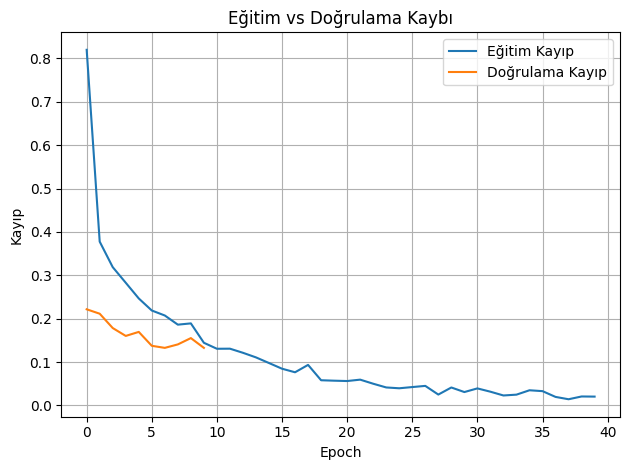

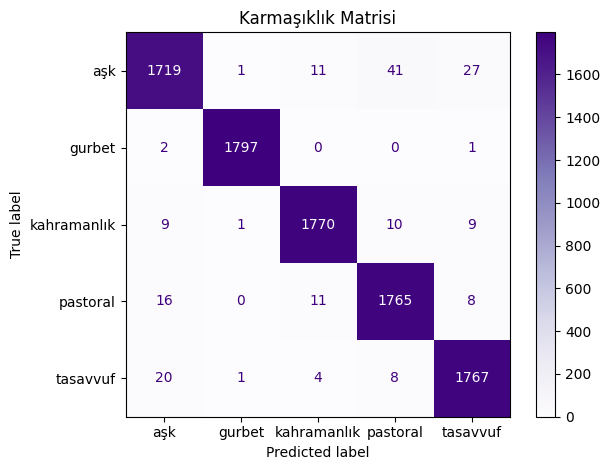

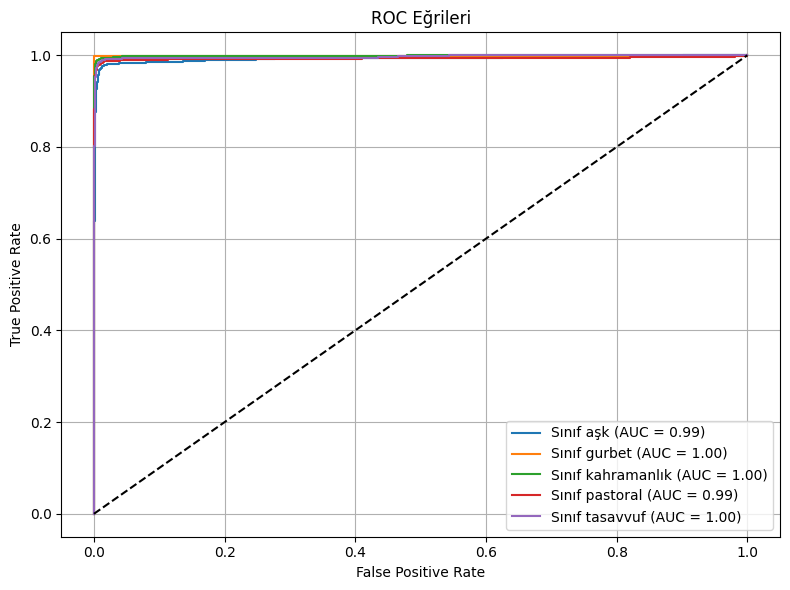

In [ ]:
# ✅ Kurulumlar
# Bu sıralama önemli: numpy'yi önce kuruyoruz.
!pip install numpy==1.26.4 --quiet
!pip install transformers datasets evaluate scikit-learn matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize, LabelEncoder # <-- LabelEncoder eklendi

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)

# ✅ Ortam ayarları
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Dosya yolları
# ✅ Veri yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
output_dir = "/content/drive/MyDrive/turkish_electra_model"
os.makedirs(output_dir, exist_ok=True)

# ✅ JSON verilerini yükle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset oluştur
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

# --- BURADA BÜYÜK DEĞİŞİKLİK YAPIYORUZ: Etiketleri Sayısallaştırma ---

# 1. Tüm 'konu' etiketlerini topla ve benzersizlerini bul
all_konu_labels = sorted(list(set([d['konu'] for d in train_data + val_data])))

# 2. LabelEncoder'ı tanımla ve etiketleri sığdır (fit)
label_encoder = LabelEncoder()
label_encoder.fit(all_konu_labels)

# 3. Etiketleri dönüştürme fonksiyonu
def encode_labels(example):
    example['konu'] = label_encoder.transform([example['konu']])[0]
    return example

# Dataset'leri dönüştürme fonksiyonu ile işle
train_dataset = train_dataset.map(encode_labels)
val_dataset = val_dataset.map(encode_labels)

# ✅ 'konu' sütununu 'labels' olarak yeniden adlandır
train_dataset = train_dataset.rename_column("konu", "labels")
val_dataset = val_dataset.rename_column("konu", "labels")

# --- DEĞİŞİKLİK SONU ---

# ✅ Tokenizer ve model ismi
model_name = "dbmdz/electra-base-turkish-cased-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Tokenize etme fonksiyonu
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

# ✅ Tokenize et
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# ✅ Sadece gerekli sütunları bırak
required_cols = ["input_ids", "attention_mask", "labels"]
train_dataset = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in required_cols])
val_dataset = val_dataset.remove_columns([col for col in val_dataset.column_names if col not in required_cols])

# ✅ Formatı torch olarak ayarla
# Bu satır, 'labels' sütununun PyTorch tensörüne dönüştürülmesini sağlar.
# Öncesinde Python int tipinde olması gerekiyor.
train_dataset.set_format("torch", columns=required_cols)
val_dataset.set_format("torch", columns=required_cols)

# ✅ Modeli yükle
# Etiket sayısını (num_labels) dinamik olarak belirle
# Artık labels'lar zaten integer olduğu için bu kısım sorunsuz çalışmalı
num_labels = len(label_encoder.classes_) # LabelEncoder'dan doğrudan sınıf sayısını alabiliriz

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# ✅ Metrik fonksiyonu
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)

    cm = confusion_matrix(labels, preds)
    specificity_list, sensitivity_list = [], []
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        specificity_list.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        sensitivity_list.append(tp / (tp + fn) if (tp + fn) != 0 else 0)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list)
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

# ✅ Trainer nesnesi
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ✅ Eğitim başlat
start_train = time.time()
trainer.train()
end_train = time.time()
print(f"🕒 Eğitim süresi: {end_train - start_train:.2f} saniye")

# ✅ Değerlendirme
start_eval = time.time()
metrics = trainer.evaluate()
end_eval = time.time()
print(f"🕒 Inference süresi: {end_eval - start_eval:.2f} saniye")
print("📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# ✅ Kayıp grafiği
logs = trainer.state.log_history
train_loss = [x["loss"] for x in logs if "loss" in x]
eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.plot(train_loss, label="Eğitim Kayıp")
plt.plot(eval_loss, label="Doğrulama Kayıp")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.title("Eğitim vs Doğrulama Kaybı")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/loss_plot.png")
plt.show()

# ✅ Karmaşıklık Matrisi
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
# Sınıf isimlerini orijinal metin etiketlerinden almak için
class_names = label_encoder.inverse_transform(sorted(list(set(y_true))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Purples")
plt.title("Karmaşıklık Matrisi")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# ✅ ROC Eğrileri
y_score = predictions.predictions
unique_labels = sorted(list(set(y_true))) # Sayısal etiketleri kullanıyoruz
y_bin = label_binarize(y_true, classes=unique_labels)

plt.figure(figsize=(8, 6))
for i in range(len(unique_labels)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    # Sınıf adlarını orijinal metin etiketlerinden alarak daha anlaşılır hale getiriyoruz
    class_name_for_plot = label_encoder.inverse_transform([unique_labels[i]])[0]
    plt.plot(fpr, tpr, label=f"Sınıf {class_name_for_plot} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/roc_curves.png")
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-170638167.py:150: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity
1,0.284700,0.221253,0.933652,0.935292,0.933653,0.933897,0.933653,0.983414
2,0.168400,0.177127,0.950545,0.951808,0.950545,0.950600,0.950545,0.987636
3,0.099600,0.153767,0.964103,0.964145,0.964100,0.963998,0.964100,0.991026
4,0.058800,0.126655,0.973772,0.974104,0.973771,0.973845,0.973771,0.993443
5,0.040500,0.124118,0.977773,0.977777,0.977772,0.977738,0.977772,0.994443
6,0.027600,0.108876,0.979773,0.979754,0.979772,0.979759,0.979772,0.994943
7,0.024000,0.136123,0.978995,0.979032,0.978994,0.978966,0.978994,0.994749
8,0.021700,0.139044,0.977773,0.977974,0.977770,0.977784,0.977770,0.994443


🕒 Eğitim süresi: 3178.30 saniye


🕒 Inference süresi: 30.40 saniye
📊 Değerlendirme Metrikleri:
eval_loss: 0.1089
eval_accuracy: 0.9798
eval_precision: 0.9798
eval_recall: 0.9798
eval_f1: 0.9798
eval_sensitivity: 0.9798
eval_specificity: 0.9949
eval_runtime: 30.3917
eval_samples_per_second: 296.0680
eval_steps_per_second: 9.2790
epoch: 8.0000


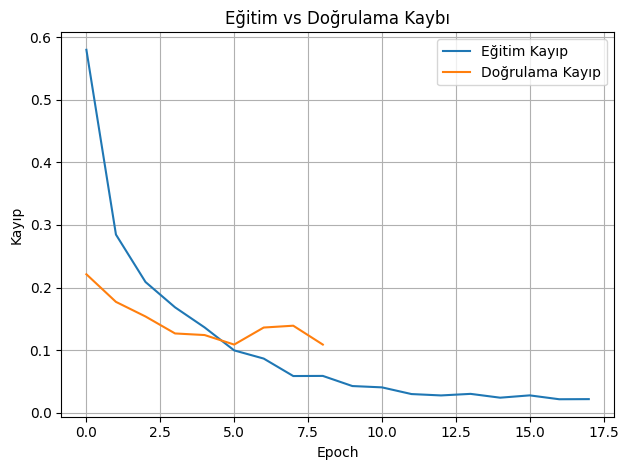

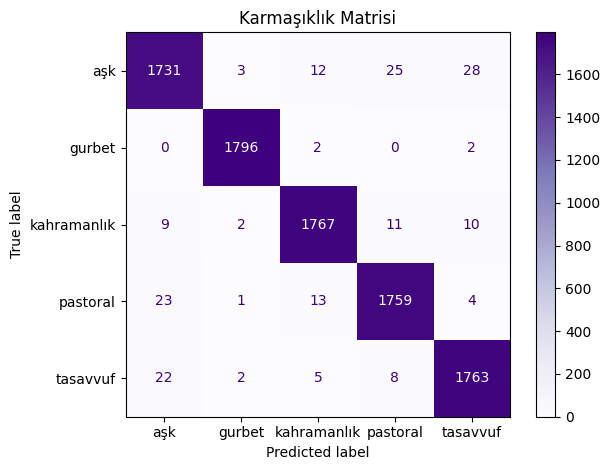

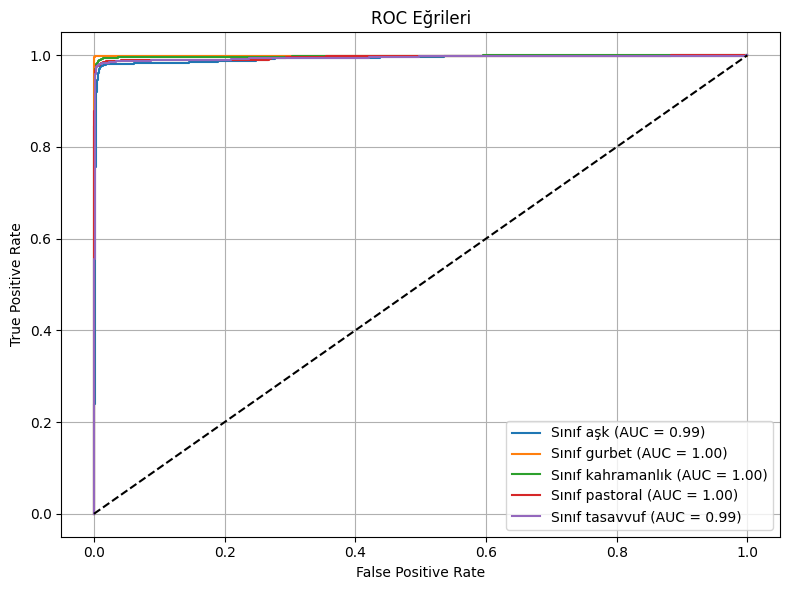

In [ ]:
# ✅ Kurulumlar
# Bu sıralama önemli: numpy'yi önce kuruyoruz.
!pip install numpy==1.26.4 --quiet
!pip install transformers datasets evaluate scikit-learn matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize, LabelEncoder # <-- LabelEncoder eklendi

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)

# ✅ Ortam ayarları
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Dosya yolları
# ✅ Veri yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
output_dir = "/content/drive/MyDrive/turkish_electra_model"
os.makedirs(output_dir, exist_ok=True)

# ✅ JSON verilerini yükle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset oluştur
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

# --- BURADA BÜYÜK DEĞİŞİKLİK YAPIYORUZ: Etiketleri Sayısallaştırma ---

# 1. Tüm 'konu' etiketlerini topla ve benzersizlerini bul
all_konu_labels = sorted(list(set([d['konu'] for d in train_data + val_data])))

# 2. LabelEncoder'ı tanımla ve etiketleri sığdır (fit)
label_encoder = LabelEncoder()
label_encoder.fit(all_konu_labels)

# 3. Etiketleri dönüştürme fonksiyonu
def encode_labels(example):
    example['konu'] = label_encoder.transform([example['konu']])[0]
    return example

# Dataset'leri dönüştürme fonksiyonu ile işle
train_dataset = train_dataset.map(encode_labels)
val_dataset = val_dataset.map(encode_labels)

# ✅ 'konu' sütununu 'labels' olarak yeniden adlandır
train_dataset = train_dataset.rename_column("konu", "labels")
val_dataset = val_dataset.rename_column("konu", "labels")

# --- DEĞİŞİKLİK SONU ---

# ✅ Tokenizer ve model ismi
model_name = "dbmdz/electra-base-turkish-cased-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Tokenize etme fonksiyonu
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

# ✅ Tokenize et
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# ✅ Sadece gerekli sütunları bırak
required_cols = ["input_ids", "attention_mask", "labels"]
train_dataset = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in required_cols])
val_dataset = val_dataset.remove_columns([col for col in val_dataset.column_names if col not in required_cols])

# ✅ Formatı torch olarak ayarla
# Bu satır, 'labels' sütununun PyTorch tensörüne dönüştürülmesini sağlar.
# Öncesinde Python int tipinde olması gerekiyor.
train_dataset.set_format("torch", columns=required_cols)
val_dataset.set_format("torch", columns=required_cols)

# ✅ Modeli yükle
# Etiket sayısını (num_labels) dinamik olarak belirle
# Artık labels'lar zaten integer olduğu için bu kısım sorunsuz çalışmalı
num_labels = len(label_encoder.classes_) # LabelEncoder'dan doğrudan sınıf sayısını alabiliriz

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# ✅ Metrik fonksiyonu
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)

    cm = confusion_matrix(labels, preds)
    specificity_list, sensitivity_list = [], []
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        specificity_list.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        sensitivity_list.append(tp / (tp + fn) if (tp + fn) != 0 else 0)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list)
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

# ✅ Trainer nesnesi
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ✅ Eğitim başlat
start_train = time.time()
trainer.train()
end_train = time.time()
print(f"🕒 Eğitim süresi: {end_train - start_train:.2f} saniye")

# ✅ Değerlendirme
start_eval = time.time()
metrics = trainer.evaluate()
end_eval = time.time()
print(f"🕒 Inference süresi: {end_eval - start_eval:.2f} saniye")
print("📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# ✅ Kayıp grafiği
logs = trainer.state.log_history
train_loss = [x["loss"] for x in logs if "loss" in x]
eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.plot(train_loss, label="Eğitim Kayıp")
plt.plot(eval_loss, label="Doğrulama Kayıp")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.title("Eğitim vs Doğrulama Kaybı")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/loss_plot.png")
plt.show()

# ✅ Karmaşıklık Matrisi
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
# Sınıf isimlerini orijinal metin etiketlerinden almak için
class_names = label_encoder.inverse_transform(sorted(list(set(y_true))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Purples")
plt.title("Karmaşıklık Matrisi")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# ✅ ROC Eğrileri
y_score = predictions.predictions
unique_labels = sorted(list(set(y_true))) # Sayısal etiketleri kullanıyoruz
y_bin = label_binarize(y_true, classes=unique_labels)

plt.figure(figsize=(8, 6))
for i in range(len(unique_labels)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    # Sınıf adlarını orijinal metin etiketlerinden alarak daha anlaşılır hale getiriyoruz
    class_name_for_plot = label_encoder.inverse_transform([unique_labels[i]])[0]
    plt.plot(fpr, tpr, label=f"Sınıf {class_name_for_plot} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/roc_curves.png")
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-1309754400.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity
1,0.346400,0.279685,0.915870,0.917099,0.915869,0.916283,0.915869,0.978968
2,0.234100,0.234564,0.934652,0.935825,0.934651,0.934894,0.934651,0.983663
3,0.173500,0.200493,0.950656,0.951236,0.950654,0.950820,0.950654,0.987664
4,0.141000,0.184736,0.959880,0.960059,0.959878,0.959951,0.959878,0.989970
5,0.110900,0.182370,0.962547,0.962623,0.962546,0.962486,0.962546,0.990637
6,0.091300,0.147121,0.969993,0.970026,0.969992,0.970004,0.969992,0.992498
7,0.076700,0.169927,0.969882,0.969939,0.969879,0.969801,0.969879,0.992471


🕒 Eğitim süresi: 2999.18 saniye


🕒 Inference süresi: 31.93 saniye
📊 Değerlendirme Metrikleri:
eval_loss: 0.1471
eval_accuracy: 0.9700
eval_precision: 0.9700
eval_recall: 0.9700
eval_f1: 0.9700
eval_sensitivity: 0.9700
eval_specificity: 0.9925
eval_runtime: 31.9290
eval_samples_per_second: 281.8130
eval_steps_per_second: 17.6330
epoch: 7.0000


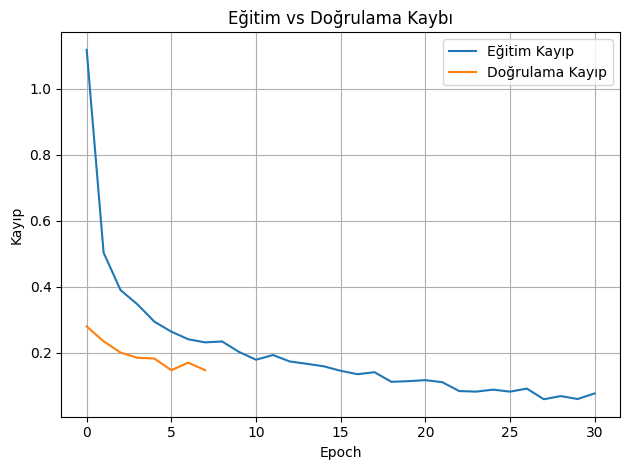

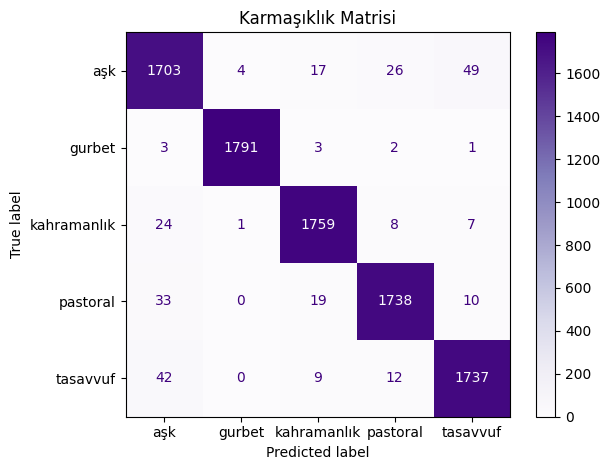

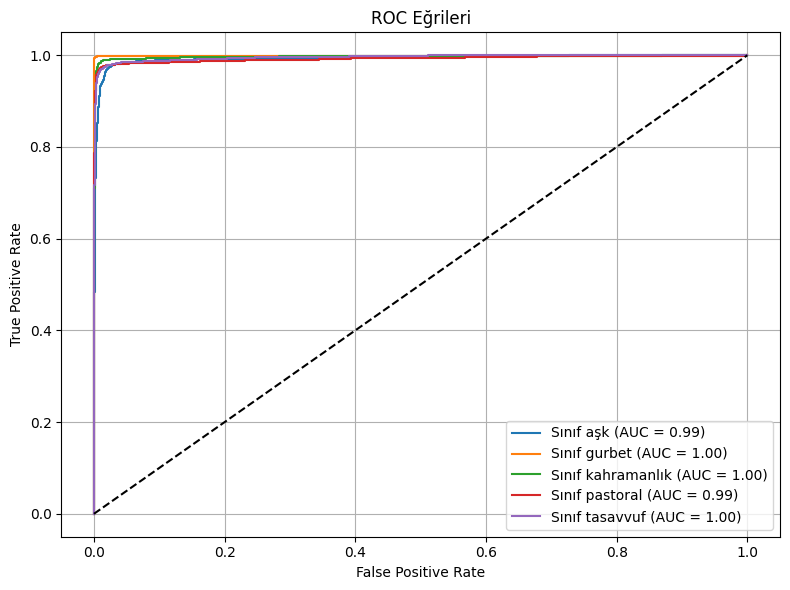

In [ ]:
# ✅ Kurulumlar
# Bu sıralama önemli: numpy'yi önce kuruyoruz.
!pip install numpy==1.26.4 --quiet
!pip install transformers datasets evaluate scikit-learn matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize, LabelEncoder # <-- LabelEncoder eklendi

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)

# ✅ Ortam ayarları
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

# ✅ Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Dosya yolları
# ✅ Veri yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
output_dir = "/content/drive/MyDrive/turkish_electra_model"
os.makedirs(output_dir, exist_ok=True)

# ✅ JSON verilerini yükle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset oluştur
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

# --- BURADA BÜYÜK DEĞİŞİKLİK YAPIYORUZ: Etiketleri Sayısallaştırma ---

# 1. Tüm 'konu' etiketlerini topla ve benzersizlerini bul
all_konu_labels = sorted(list(set([d['konu'] for d in train_data + val_data])))

# 2. LabelEncoder'ı tanımla ve etiketleri sığdır (fit)
label_encoder = LabelEncoder()
label_encoder.fit(all_konu_labels)

# 3. Etiketleri dönüştürme fonksiyonu
def encode_labels(example):
    example['konu'] = label_encoder.transform([example['konu']])[0]
    return example

# Dataset'leri dönüştürme fonksiyonu ile işle
train_dataset = train_dataset.map(encode_labels)
val_dataset = val_dataset.map(encode_labels)

# ✅ 'konu' sütununu 'labels' olarak yeniden adlandır
train_dataset = train_dataset.rename_column("konu", "labels")
val_dataset = val_dataset.rename_column("konu", "labels")

# --- DEĞİŞİKLİK SONU ---

# ✅ Tokenizer ve model ismi
model_name = "dbmdz/electra-base-turkish-cased-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Tokenize etme fonksiyonu
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

# ✅ Tokenize et
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# ✅ Sadece gerekli sütunları bırak
required_cols = ["input_ids", "attention_mask", "labels"]
train_dataset = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in required_cols])
val_dataset = val_dataset.remove_columns([col for col in val_dataset.column_names if col not in required_cols])

# ✅ Formatı torch olarak ayarla
# Bu satır, 'labels' sütununun PyTorch tensörüne dönüştürülmesini sağlar.
# Öncesinde Python int tipinde olması gerekiyor.
train_dataset.set_format("torch", columns=required_cols)
val_dataset.set_format("torch", columns=required_cols)

# ✅ Modeli yükle
# Etiket sayısını (num_labels) dinamik olarak belirle
# Artık labels'lar zaten integer olduğu için bu kısım sorunsuz çalışmalı
num_labels = len(label_encoder.classes_) # LabelEncoder'dan doğrudan sınıf sayısını alabiliriz

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# ✅ Metrik fonksiyonu
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)

    cm = confusion_matrix(labels, preds)
    specificity_list, sensitivity_list = [], []
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        specificity_list.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        sensitivity_list.append(tp / (tp + fn) if (tp + fn) != 0 else 0)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list)
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-6,                        # daha düşük öğrenme oranı
    per_device_train_batch_size=16,           # batch size azaltıldı
    per_device_eval_batch_size=16,
    num_train_epochs=50,                      # daha makul
    weight_decay=0.05,                        # regularization artırıldı
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # daha erken durdurma
)

# ✅ Eğitim başlat
start_train = time.time()
trainer.train()
end_train = time.time()
print(f"🕒 Eğitim süresi: {end_train - start_train:.2f} saniye")

# ✅ Değerlendirme
start_eval = time.time()
metrics = trainer.evaluate()
end_eval = time.time()
print(f"🕒 Inference süresi: {end_eval - start_eval:.2f} saniye")
print("📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# ✅ Kayıp grafiği
logs = trainer.state.log_history
train_loss = [x["loss"] for x in logs if "loss" in x]
eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.plot(train_loss, label="Eğitim Kayıp")
plt.plot(eval_loss, label="Doğrulama Kayıp")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.title("Eğitim vs Doğrulama Kaybı")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/loss_plot.png")
plt.show()

# ✅ Karmaşıklık Matrisi
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
# Sınıf isimlerini orijinal metin etiketlerinden almak için
class_names = label_encoder.inverse_transform(sorted(list(set(y_true))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Purples")
plt.title("Karmaşıklık Matrisi")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# ✅ ROC Eğrileri
y_score = predictions.predictions
unique_labels = sorted(list(set(y_true))) # Sayısal etiketleri kullanıyoruz
y_bin = label_binarize(y_true, classes=unique_labels)

plt.figure(figsize=(8, 6))
for i in range(len(unique_labels)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    # Sınıf adlarını orijinal metin etiketlerinden alarak daha anlaşılır hale getiriyoruz
    class_name_for_plot = label_encoder.inverse_transform([unique_labels[i]])[0]
    plt.plot(fpr, tpr, label=f"Sınıf {class_name_for_plot} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/roc_curves.png")
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-6-2667269261.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity
1,0.484900,0.434984,0.920760,0.922521,0.920760,0.921270,0.920760,0.980191
2,0.401700,0.391922,0.939209,0.939765,0.939206,0.939399,0.939206,0.984802
3,0.352800,0.374824,0.949655,0.949688,0.949652,0.949642,0.949652,0.987414
4,0.318100,0.362755,0.957546,0.957865,0.957543,0.957621,0.957543,0.989387
5,0.291200,0.350814,0.962658,0.962970,0.962658,0.962640,0.962658,0.990665
6,0.289900,0.336940,0.964659,0.964841,0.964654,0.964583,0.964654,0.991165
7,0.274800,0.347651,0.964325,0.964766,0.964320,0.964163,0.964320,0.991081


🕒 Eğitim süresi: 3002.08 saniye


🕒 Inference süresi: 32.03 saniye
📊 Değerlendirme Metrikleri:
eval_loss: 0.3369
eval_accuracy: 0.9647
eval_precision: 0.9648
eval_recall: 0.9647
eval_f1: 0.9646
eval_sensitivity: 0.9647
eval_specificity: 0.9912
eval_runtime: 32.0238
eval_samples_per_second: 280.9780
eval_steps_per_second: 17.5810
epoch: 7.0000


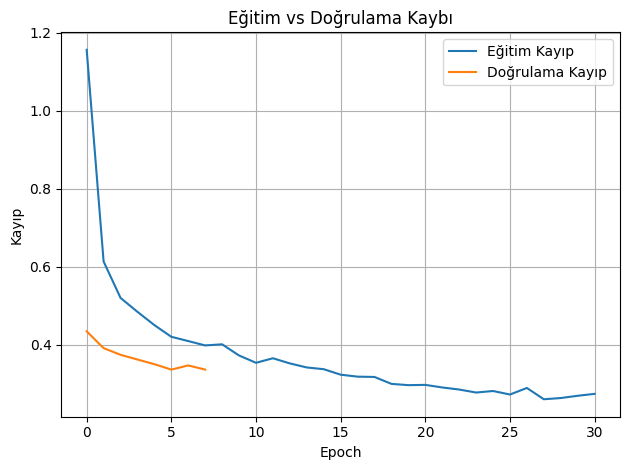

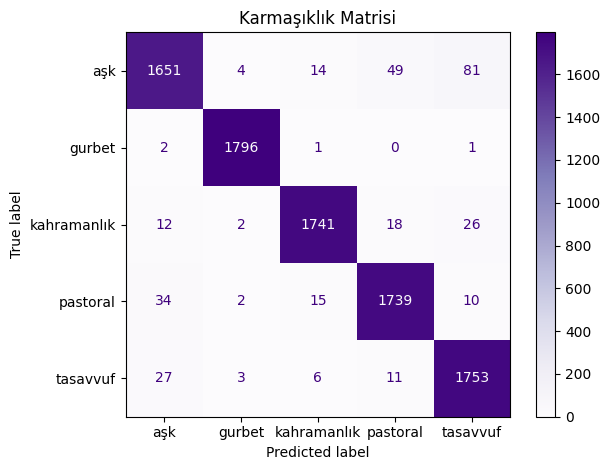

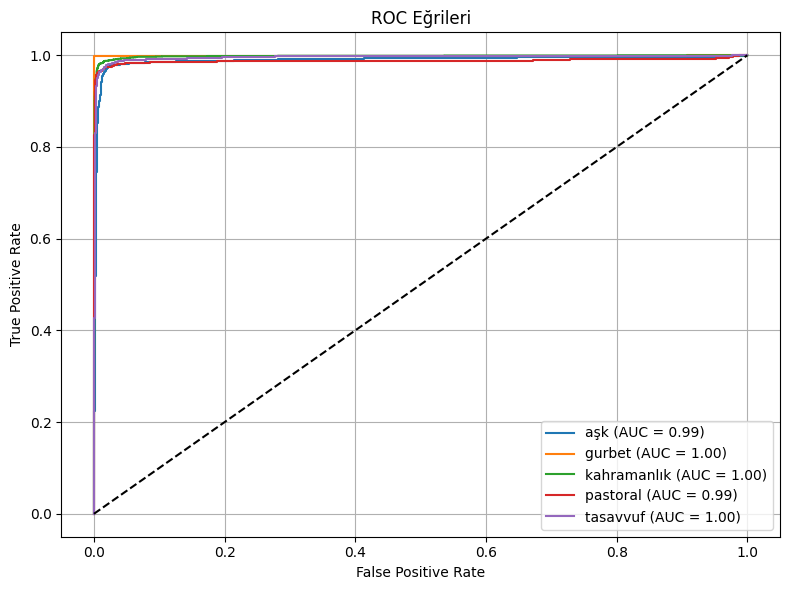

In [ ]:
# ✅ Kurulumlar
!pip install numpy==1.26.4 --quiet
!pip install transformers datasets evaluate scikit-learn matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize, LabelEncoder
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)

# ✅ Ortam ayarları
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
os.environ["WANDB_DISABLED"] = "true"

# ✅ Google Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
output_dir = "/content/drive/MyDrive/turkish_electra_model"
os.makedirs(output_dir, exist_ok=True)

# ✅ JSON verilerini yükle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset oluştur
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

# ✅ Etiketleri sayısallaştır
all_konu_labels = sorted(list(set([d['konu'] for d in train_data + val_data])))
label_encoder = LabelEncoder()
label_encoder.fit(all_konu_labels)

def encode_labels(example):
    example['konu'] = label_encoder.transform([example['konu']])[0]
    return example

train_dataset = train_dataset.map(encode_labels)
val_dataset = val_dataset.map(encode_labels)

train_dataset = train_dataset.rename_column("konu", "labels")
val_dataset = val_dataset.rename_column("konu", "labels")

# ✅ Tokenizer
model_name = "dbmdz/electra-base-turkish-cased-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Tokenizasyon
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# ✅ Formatlama
required_cols = ["input_ids", "attention_mask", "labels"]
train_dataset = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in required_cols])
val_dataset = val_dataset.remove_columns([col for col in val_dataset.column_names if col not in required_cols])
train_dataset.set_format("torch", columns=required_cols)
val_dataset.set_format("torch", columns=required_cols)

# ✅ Model
num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# ✅ Metrikler
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)

    cm = confusion_matrix(labels, preds)
    specificity_list, sensitivity_list = [], []
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        specificity_list.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        sensitivity_list.append(tp / (tp + fn) if (tp + fn) != 0 else 0)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list)
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.05,
    label_smoothing_factor=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# ✅ Eğitim
start_train = time.time()
trainer.train()
end_train = time.time()
print(f"🕒 Eğitim süresi: {end_train - start_train:.2f} saniye")

# ✅ Değerlendirme
start_eval = time.time()
metrics = trainer.evaluate()
end_eval = time.time()
print(f"🕒 Inference süresi: {end_eval - start_eval:.2f} saniye")
print("📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# ✅ Loss grafiği (düzenli epoch bazlı)
logs = trainer.state.log_history
train_loss = [x["loss"] for x in logs if "loss" in x and "epoch" in x]
eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.plot(train_loss, label="Eğitim Kayıp")
plt.plot(eval_loss, label="Doğrulama Kayıp")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.title("Eğitim vs Doğrulama Kaybı")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/loss_plot.png")
plt.show()

# ✅ Karmaşıklık Matrisi
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.inverse_transform(sorted(list(set(y_true))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Purples")
plt.title("Karmaşıklık Matrisi")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# ✅ ROC Eğrileri
y_score = predictions.predictions
unique_labels = sorted(list(set(y_true)))
y_bin = label_binarize(y_true, classes=unique_labels)

plt.figure(figsize=(8, 6))
for i in range(len(unique_labels)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    class_name_for_plot = label_encoder.inverse_transform([unique_labels[i]])[0]
    plt.plot(fpr, tpr, label=f"{class_name_for_plot} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/roc_curves.png")
plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-8-2074210360.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity
1,0.498500,0.439317,0.916759,0.918358,0.916758,0.917245,0.916758,0.979190
2,0.402400,0.403431,0.938653,0.938913,0.938649,0.938695,0.938649,0.984663
3,0.350400,0.377449,0.951323,0.951411,0.951318,0.951308,0.951318,0.987831
4,0.319000,0.363236,0.957880,0.958044,0.957877,0.957930,0.957877,0.989470
5,0.291700,0.342618,0.964881,0.964897,0.964880,0.964867,0.964880,0.991220
6,0.287000,0.335171,0.966326,0.966485,0.966322,0.966228,0.966322,0.991582
7,0.269900,0.320007,0.974550,0.974653,0.974549,0.974581,0.974549,0.993638
8,0.261100,0.310590,0.976106,0.976265,0.976104,0.976139,0.976104,0.994027
9,0.249000,0.311868,0.977106,0.977086,0.977104,0.977060,0.977104,0.994277


🕒 Eğitim süresi: 3870.86 saniye


🕒 Inference süresi: 32.02 saniye
📊 Değerlendirme Metrikleri:
eval_loss: 0.3106
eval_accuracy: 0.9761
eval_precision: 0.9763
eval_recall: 0.9761
eval_f1: 0.9761
eval_sensitivity: 0.9761
eval_specificity: 0.9940
eval_runtime: 32.0205
eval_samples_per_second: 281.0070
eval_steps_per_second: 17.5820
epoch: 9.0000


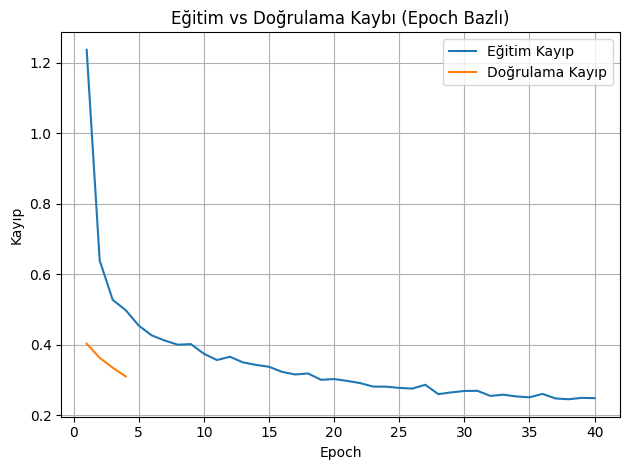

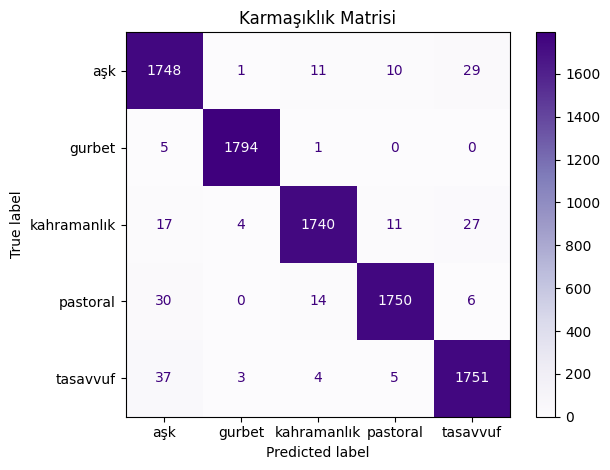

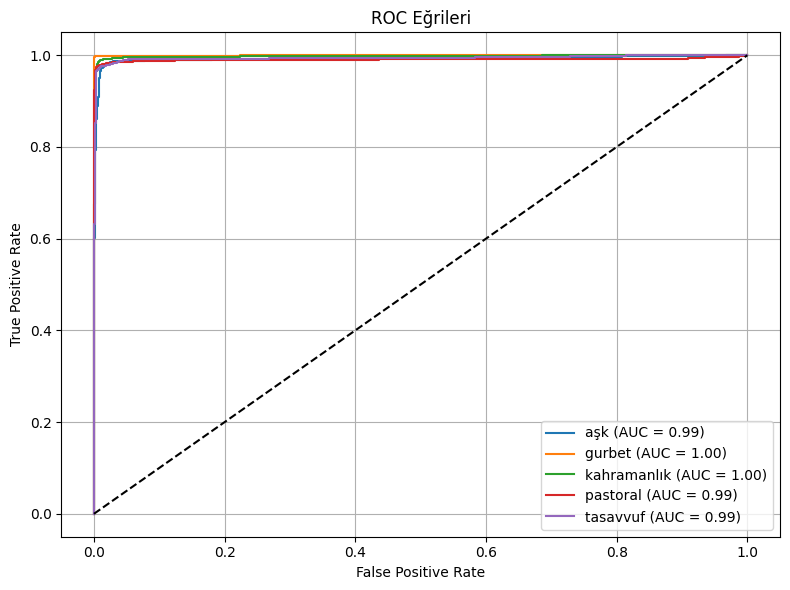

In [ ]:
# ✅ Kurulumlar
!pip install numpy==1.26.4 --quiet
!pip install transformers datasets evaluate scikit-learn matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize, LabelEncoder
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)

# ✅ Ortam ayarları
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
os.environ["WANDB_DISABLED"] = "true"

# ✅ Google Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Dosya yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
output_dir = "/content/drive/MyDrive/turkish_electra_model"
os.makedirs(output_dir, exist_ok=True)

# ✅ JSON verilerini yükle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset oluştur
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

# ✅ Etiketleri sayısallaştır
all_konu_labels = sorted(list(set([d['konu'] for d in train_data + val_data])))
label_encoder = LabelEncoder()
label_encoder.fit(all_konu_labels)

def encode_labels(example):
    example['konu'] = label_encoder.transform([example['konu']])[0]
    return example

train_dataset = train_dataset.map(encode_labels)
val_dataset = val_dataset.map(encode_labels)

train_dataset = train_dataset.rename_column("konu", "labels")
val_dataset = val_dataset.rename_column("konu", "labels")

# ✅ Tokenizer
model_name = "dbmdz/electra-base-turkish-cased-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Tokenizasyon
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# ✅ Formatlama
required_cols = ["input_ids", "attention_mask", "labels"]
train_dataset = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in required_cols])
val_dataset = val_dataset.remove_columns([col for col in val_dataset.column_names if col not in required_cols])
train_dataset.set_format("torch", columns=required_cols)
val_dataset.set_format("torch", columns=required_cols)

# ✅ Model
num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# ✅ Metrikler
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)

    cm = confusion_matrix(labels, preds)
    specificity_list, sensitivity_list = [], []
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        specificity_list.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        sensitivity_list.append(tp / (tp + fn) if (tp + fn) != 0 else 0)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list)
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.05,
    label_smoothing_factor=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# ✅ Eğitim
start_train = time.time()
trainer.train()
end_train = time.time()
print(f"🕒 Eğitim süresi: {end_train - start_train:.2f} saniye")

# ✅ Değerlendirme
start_eval = time.time()
metrics = trainer.evaluate()
end_eval = time.time()
print(f"🕒 Inference süresi: {end_eval - start_eval:.2f} saniye")
print("📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# ✅ Loss Grafiği (Sadece epoch sonu)
logs = trainer.state.log_history
epochs = sorted(set([log["epoch"] for log in logs if "loss" in log]))

train_loss_epoch = []
eval_loss_epoch = []

for epoch in epochs:
    epoch_logs = [log for log in logs if log.get("epoch") == epoch]
    epoch_train_losses = [log["loss"] for log in epoch_logs if "loss" in log]
    epoch_eval_losses = [log["eval_loss"] for log in epoch_logs if "eval_loss" in log]

    if epoch_train_losses:
        train_loss_epoch.append(epoch_train_losses[-1])
    if epoch_eval_losses:
        eval_loss_epoch.append(epoch_eval_losses[-1])

plt.plot(range(1, len(train_loss_epoch)+1), train_loss_epoch, label="Eğitim Kayıp")
plt.plot(range(1, len(eval_loss_epoch)+1), eval_loss_epoch, label="Doğrulama Kayıp")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.title("Eğitim vs Doğrulama Kaybı (Epoch Bazlı)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/loss_plot_epoch_based.png")
plt.show()

# ✅ Karmaşıklık Matrisi
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.inverse_transform(sorted(list(set(y_true))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Purples")
plt.title("Karmaşıklık Matrisi")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# ✅ ROC Eğrileri
y_score = predictions.predictions
unique_labels = sorted(list(set(y_true)))
y_bin = label_binarize(y_true, classes=unique_labels)

plt.figure(figsize=(8, 6))
for i in range(len(unique_labels)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    class_name_for_plot = label_encoder.inverse_transform([unique_labels[i]])[0]
    plt.plot(fpr, tpr, label=f"{class_name_for_plot} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/roc_curves.png")
plt.show()


In [ ]:
# ✅ NumPy sürümünü düşür ve ortamı yeniden başlat
import os
os.system("pip install numpy==1.26.4 --quiet")
os.kill(os.getpid(), 9)  # Runtime'ı zorla yeniden başlatır
